<a href="https://colab.research.google.com/github/ProudFaceOfSUiR/AI_lab3/blob/master/Copy_of_Transfer_Learning_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [9]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Classify Flowers with Transfer Learning


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_feature_vector"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

Have you ever seen a beautiful flower and wondered what kind of flower it is? Well, you're not the first, so let's build a way to identify the type of flower from a photo!

For classifying images, a particular type of *deep neural network*, called a *convolutional neural network* has proved to be particularly powerful. However, modern convolutional neural networks have millions of parameters. Training them from scratch requires a lot of labeled training data and a lot of computing power (hundreds of GPU-hours or more). We only have about three thousand labeled photos and want to spend much less time, so we need to be more clever.

We will use a technique called *transfer learning* where we take a pre-trained network (trained on about a million general images), use it to extract features, and train a new layer on top for our own task of classifying images of flowers.


## Setup


In [10]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

## The flowers dataset

The flowers dataset consists of images of flowers with 5 possible class labels.

When training a machine learning model, we split our data into training and test datasets. We will train the model on our training data and then evaluate how well the model performs on data it has never seen - the test set.

Let's download our training and test examples (it may take a while) and split them into train and test sets.

Run the following two cells:

In [11]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [12]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


## Explore the data

The flowers dataset consists of examples which are labeled images of flowers. Each example contains a JPEG flower image and the class label: what type of flower it is. Let's display a few images together with their labels.

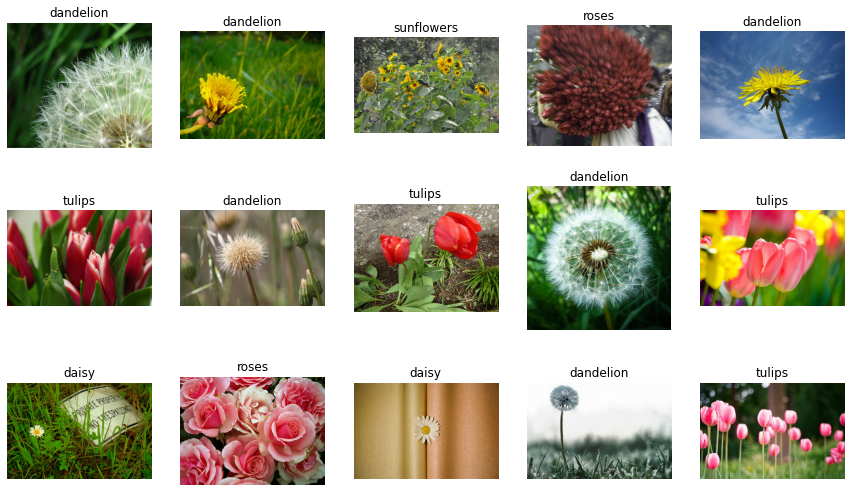

In [13]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 15 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

## Build the model

We will load a [TF-Hub](https://tensorflow.org/hub) image feature vector module, stack a linear classifier on it, and add training and evaluation ops. The following cell builds a TF graph describing the model and its training, but it doesn't run the training (that will be the next step).

In [14]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)


def decode_and_resize_image(encoded):
  decoded = tf.image.decode_jpeg(encoded, channels=3)
  decoded = tf.image.convert_image_dtype(decoded, tf.float32)
  return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.
features = image_module(batch_images)


def create_model(features):
  """Build a model for classification from extracted features."""
  # Currently, the model is just a single linear layer. You can try to add
  # another layer, but be careful... two linear layers (when activation=None)
  # are equivalent to a single linear layer. You can create a nonlinear layer
  # like this:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer


# For each class (kind of flower), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


## Train the network

Now that our model is built, let's train it and see how it perfoms on our test set.

In [15]:
# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 100 #@param {type: 'integer'}
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 #@param {type: 'integer'}
# How often to evaluate the model performance.
EVAL_EVERY = 10 #@param {type: 'integer'}

def get_batch(batch_size=None, test=False):
  """Get a random batch of examples."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Get the one hot encoding vector for the example."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Get a random batch of training examples.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Run the train_op to train the model.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Get a batch of test examples.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Evaluate how well our model performs on the test set.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 19.16%
Test accuracy at step 10: 50.68%
Test accuracy at step 20: 61.28%
Test accuracy at step 30: 70.92%
Test accuracy at step 40: 72.83%
Test accuracy at step 50: 75.68%
Test accuracy at step 60: 76.36%
Test accuracy at step 70: 77.99%
Test accuracy at step 80: 77.99%
Test accuracy at step 90: 79.21%
Test accuracy at step 99: 78.53%


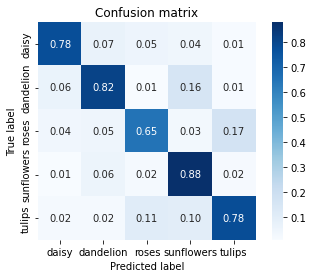

In [16]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

## Incorrect predictions

Let's a take a closer look at the test examples that our model got wrong.

- Are there any mislabeled examples in our test set?
- Is there any bad data in the test set - images that aren't actually pictures of flowers?
- Are there images where you can understand why the model made a mistake?

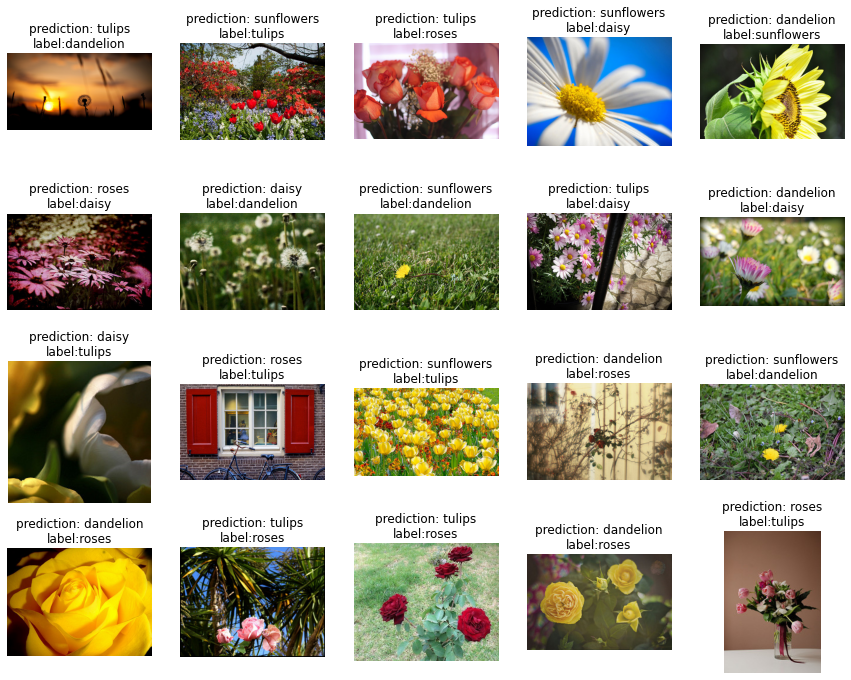

In [17]:
incorrect = [
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])

## Exercises: Improve the model!

We've trained a baseline model, now let's try to improve it to achieve better accuracy. (Remember that you'll need to re-run the cells when you make a change.)

### Exercise 1:  Try a different image model.
With TF-Hub, trying a few different image models is simple. Just replace the `"https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2"` handle in the `hub.Module()` call with a handle of different module and rerun all the code. You can see all available image modules at [tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector). 

A good choice might be one of the other [MobileNet V2 modules](https://tfhub.dev/s?module-type=image-feature-vector&network-architecture=mobilenet-v2). Many of the modules -- including the MobileNet modules -- were trained on the [ImageNet dataset](http://image-net.org/challenges/LSVRC/2012) which contains over 1 million images and 1000 classes. Choosing a network architecture provides a tradeoff between speed and classification accuracy: models like MobileNet or NASNet Mobile are fast and small, more traditional architectures like Inception and ResNet were designed for accuracy.

For the larger Inception V3 architecture, you can also explore the benefits of pre-training on a domain closer to your own task: it is also available as a [module trained on the iNaturalist dataset](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1) of plants and animals.

### Exercise 2: Add a hidden layer.
Stack a hidden layer between extracted image features and the linear classifier (in function `create_model()` above). To create a non-linear hidden layer with e.g. 100 nodes, use  [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/compat/v1/layers/dense) with units set to 100 and activation set to `tf.nn.relu`. Does changing the size of the hidden layer affect the test accuracy? Does adding second hidden layer improve the accuracy?

### Exercise 3: Change hyperparameters.
Does increasing  *number of training steps*  improves final accuracy? Can you *change the learning rate* to make your model converge more quickly? Does the training *batch size* affect your model's performance?

### Exercise 4: Try a different optimizer.

Replace the basic GradientDescentOptimizer with a more sophisticate optimizer, e.g. [AdagradOptimizer](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/AdagradOptimizer). Does it make a difference to your model training? If you want to learn more about the benefits of different optimization algorithms, check out [this post](http://ruder.io/optimizing-gradient-descent/).

## Want to learn more?

If you are interested in a more advanced version of this tutorial, check out the [TensorFlow image retraining tutorial](https://www.tensorflow.org/hub/tutorials/image_retraining) which walks you through visualizing the training using TensorBoard, advanced techniques like dataset augmentation by distorting images, and replacing the flowers dataset to learn an image classifier on your own dataset.

You can learn more about TensorFlow at [tensorflow.org](http://tensorflow.org) and see the TF-Hub API documentation is available at [tensorflow.org/hub](https://www.tensorflow.org/hub/). Find available TensorFlow Hub modules at [tfhub.dev](http://tfhub.dev) including more image feature vector modules and text embedding modules.

Also check out the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/) which is Google's fast-paced, practical introduction to machine learning.